In [16]:
'''
Author: tianhao 120090472@link.cuhk.edu.cn
Date: 2023-09-26 09:57:54
LastEditors: tianhao 120090472@link.cuhk.edu.cn
LastEditTime: 2024-02-28 16:20:05
FilePath: /DatProc/05.data_rebanalce_vis.ipynb
Description: 
    Code to visualize azimuth angle distribution of dataset before and after rebalancing
Copyright (c) 2023 by ${git_name_email}, All Rights Reserved. 
'''
import os
import json
import math
import argparse
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from scipy import stats
from multiprocessing import Pool
from matplotlib import pyplot as plt
from scipy.optimize import minimize

from dpmain.datproc_v1 import DatProcV1

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input_path", type=str, help="path to json metafile", default="/data2/PanoHeadData/single_view_hq/dataset_v2_balanced_nohat.json")
    parser.add_argument("-o", "--output_dir", type=str, help="path to output directory", default="./temp")
    parser.add_argument("-j", "--num_workers", type=int, help="number of workers", default=256)
    # parser.add_argument("--force", action="store_true", help="force to overwrite existing files")
    args, _ = parser.parse_known_args()
    return args

def get_coord(json_data):
    """
    Load camera position. A npy file is created to save. If operation is forced, the npy file will be overwritten.
    """
    coords_save_path = os.path.join(args.output_dir, "coords.npy") # ! Be sure to backup the file before overwriting
    coords = []
    if not(hasattr(args, 'force')):
        if os.path.exists(coords_save_path):
            coords = np.load(coords_save_path)

    if isinstance(coords, list):
        print(f'Calculating coords...')
        for img_meta in tqdm(json_data.values()):
            c2w = np.array(img_meta["camera"][:16]).reshape(4,4)
            # dup_num = img_meta["dup_num"]
            dup_num = 1
            theta, phi, r, x, y, z = DatProcV1.get_cam_coords(c2w)
            if theta < -90 and theta >= -180: theta += 360
            coords.extend([(theta, phi)] * dup_num)
        coords = np.array(coords)
        np.save(coords_save_path, coords)
    return coords

def get_density(coords: np.array):
    """
    Load density file. A npy file is created to save. If operation is forced, the npy file will be overwritten.
    """
    global kernel
    density_save_path = os.path.join(args.output_dir, "density.npy")
    densities = []
    kernel = stats.gaussian_kde(coords.T)
    if not(hasattr(args, 'force')):
        if os.path.exists(density_save_path):
            densities = np.load(density_save_path)

    if isinstance(densities, list):
        print(f'Calculating density...')
        for coord in tqdm(coords):
            density = kernel(coord)
            densities.append(density)
        densities = np.array(densities)
        print(f'Maximum density: {np.max(densities)}, Minimum density: {np.min(densities)}')
        np.save(density_save_path, densities)
    return densities

def get_num_duplicate(densities: np.array, bin_bounds: np.array, a=0.002):
    N = []
    Z = []
    for density in tqdm(densities):
        if density < bin_bounds[1]:
            _N = len(bin_bounds) - 1
        else:
            _N = min(len(bin_bounds) - 2, max(1, round(a/density)))
        N.append(_N)
        Z.append(density*_N)
    return N, Z

kernel = None
args = parse_args()
with open(args.input_path, 'r') as f:
    json_data = json.load(f)

In earlier versions, we try to follow LPFF's setting on data rebalancing, but later times we just try to make every azimuth angle have similar number of samples, which involves setting a threshold number and multiply any azithum angle's samples to reach the threshold. 

In [17]:
coords = get_coord(json_data)
theta = coords[:, 0]
phi = coords[:, 1]
max_dup_nums = [8]
colors = ['b', 'g', 'r', 'c']
# ! Legacy code
# densities = get_density(coords)
# densities_unique, counts = np.unique(densities, return_counts=True)
# cumulative_counts = np.cumsum(counts)
# find_percentiles = [0, 20, 40, 60, 80, 100]
# max_density = densities_unique[-1]
# for max_dup_num, color in zip(max_dup_nums, colors):
#     density_bounds = [0] + [max_density / i for i in range(max_dup_num, 0, -1)]
print(f'Total {len(theta)} Images')

Total 148351 Images


Percntile 0.1=46.28319135754526; -87.68844521665777
Percntile 50=82.37294255820304; 87.97863040805022
Percntile 99.9=118.12714164559759; 240.16637767100062


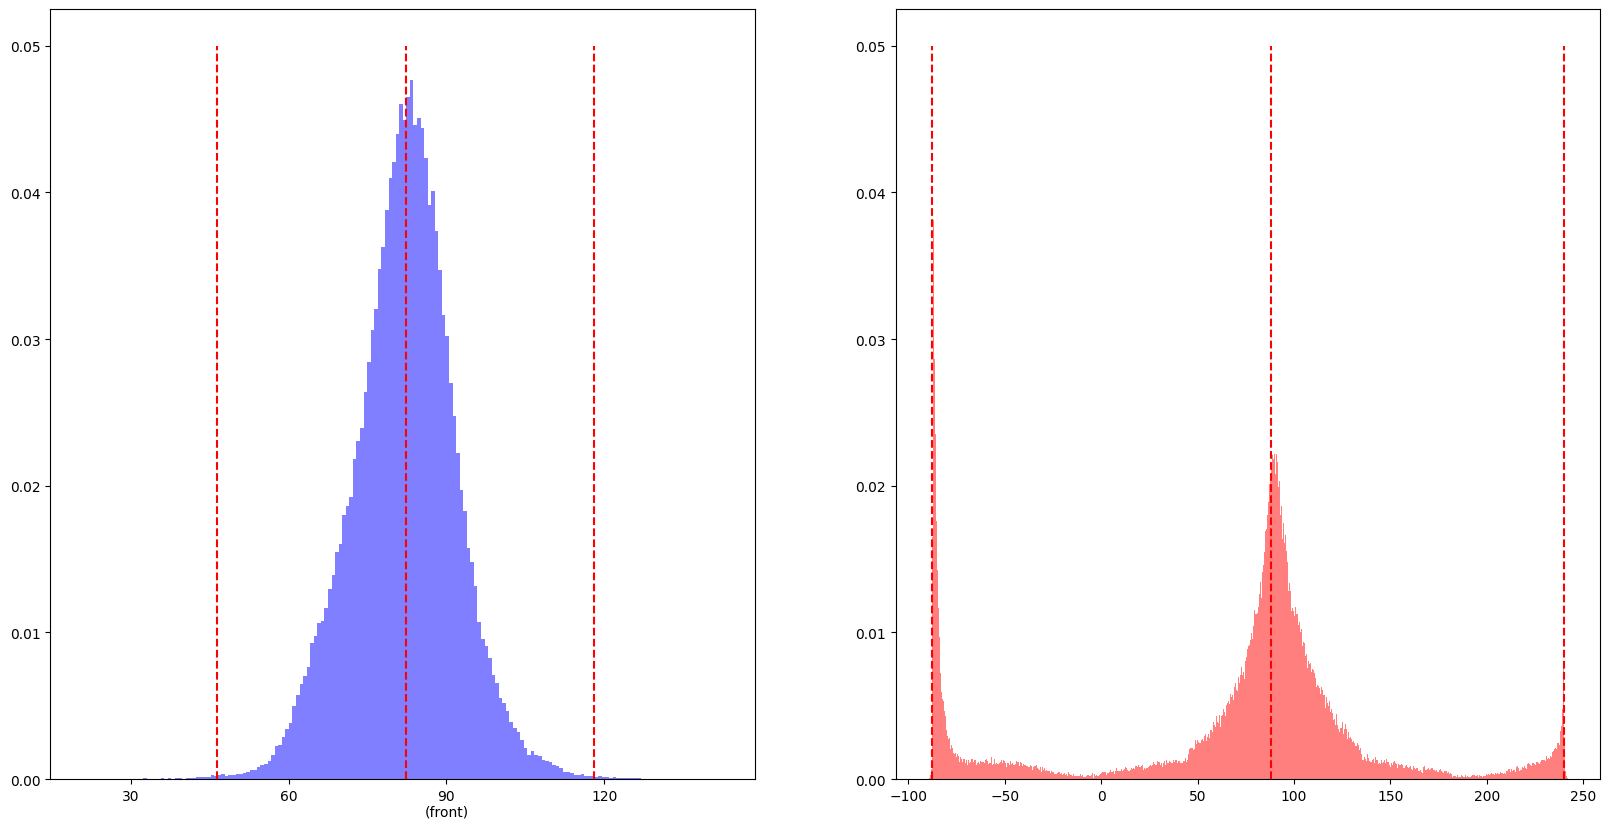

In [47]:
fig, ax5 = plt.subplots(1, 2, figsize=(20, 10))
ax5[0].hist(phi, bins=180, density=True, color='b', alpha=0.5, label=r"$\phi$")
ax5[0].set_xticks(np.arange(0, 181, 30))
ax5[0].set_xticklabels(['0\n(up)', '30', '60', '90\n(front)', '120', '150', '180\n(down)'])
ax5[1].hist(theta, bins=360, density=True, color='r', alpha=0.5, label=r"$\theta$")
# ax5[1].set_xticks(np.arange(-180, 181, 30))
# ax5[1].set_xticklabels(['-180\n(left)', '-150', '-120', '-90\n(back)', '-60', '-30', '0\n(front)', '30', '60', '90\n(right)', '120', '150', '180\n(left)'])
percentiles = [0.1, 50, 99.9]
res_phi = np.percentile(phi, percentiles)
res_theta = np.percentile(theta, percentiles)
ax5[0].vlines(res_phi, 0, 0.05, colors='r', linestyles='dashed')
ax5[1].vlines(res_theta, 0, 0.05, colors='r', linestyles='dashed')
for val_phi, val_theta, per in zip(res_phi, res_theta, percentiles):
    print(f'Percntile {per}={val_phi}; {val_theta}')
plt.show()

Total number of images: 148351
Max frequency: 4569, Min frequency: 5; multiply: 913.8


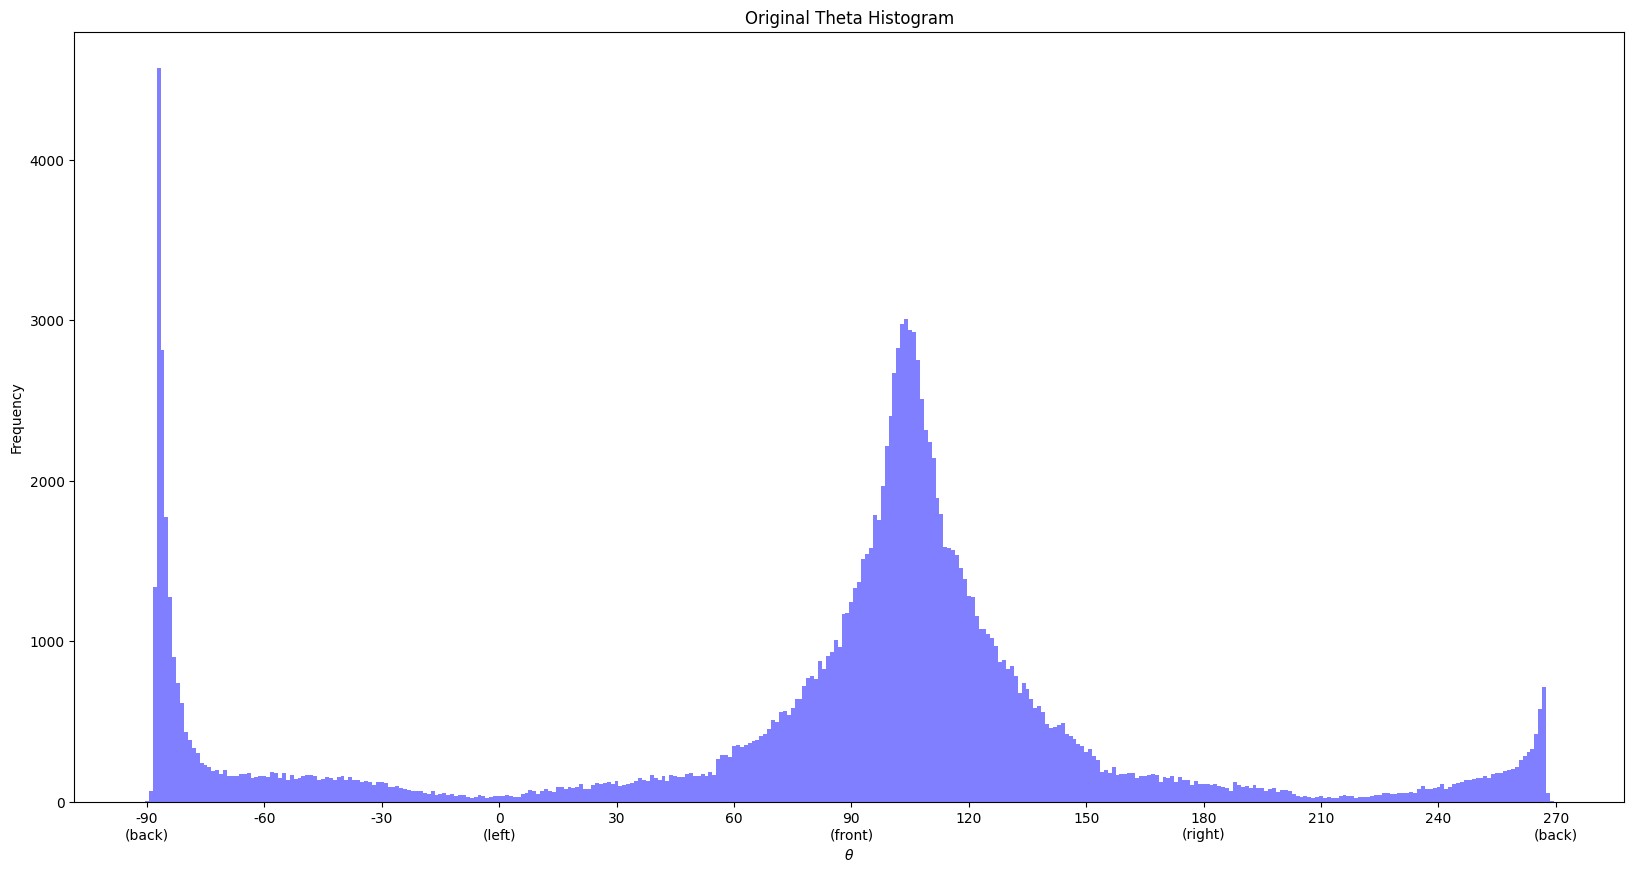

In [48]:
theta_bins = 360
theta_hist = np.histogram(theta, bins=theta_bins)
theta_hist_nums = theta_hist[0] # number of images in each bin
theta_hist_vals = theta_hist[1] # bin values
print(f'Total number of images: {np.sum(theta_hist_nums)}')
# calculate max and min frequency
max_freq = np.max(theta_hist[0])
min_freq = np.min(theta_hist[0][theta_hist[0] != 0])
new_probs = []
print(f'Max frequency: {max_freq}, Min frequency: {min_freq}; multiply: {max_freq/min_freq}')
fig, ax6 = plt.subplots(1, 1, figsize=(20, 10))
ax6.bar(range(-90, 270, 360//theta_bins), theta_hist[0], width=360//theta_bins, color='b', alpha=0.5)
ax6.set_xticks(np.arange(-90, 271, 30))
ax6.set_xticklabels(['-90\n(back)', '-60', '-30', '0\n(left)', '30', '60', '90\n(front)', '120', '150', '180\n(right)', '210', '240', '270\n(back)'])
ax6.set_xlabel(r"$\theta$")
ax6.set_ylabel("Frequency")
ax6.set_title("Original Theta Histogram")
plt.show()

In [ ]:
dup_per_deg = {}
target_nums_1 = 1500 # threshold for duplicate
new_nums = []
group_size = 5 # how many bins to group
dup_nums = []
# grouping
grouped_theta_hist_nums = [sum(theta_hist_nums[i:i+group_size]) for i in range(0, len(theta_hist_nums), group_size)]
for _theta_num in grouped_theta_hist_nums:
    if _theta_num >= target_nums_1:
        dup_num = 1
    else:
        dup_num = math.ceil(target_nums_1/_theta_num)
    dup_nums.append(dup_num)
new_nums = np.array(new_nums)
fig, ax7 = plt.subplots(1, 2, figsize=(20, 10))
ax7[0].bar(range(-90, 270,5), grouped_theta_hist_nums, width=group_size, color='b', alpha=0.5)
ax7[0].set_xticks(np.arange(-90, 271, 30))
ax7[0].set_xticklabels(['-90\n(back)', '-60', '-30', '0\n(left)', '30', '60', '90\n(front)', '120', '150', '180\n(right)', '210', '240', '270\n(back)'])
ax7[0].set_xlabel(r"$\theta$")
ax7[0].set_ylabel("Frequency")
ax7[0].set_title("Groupped Theta Histogram Before Rebalancing")

ax7[1].bar(range(-90, 270), new_nums, width=1, color='b', alpha=0.5)
ax7[1].set_xticks(np.arange(-90, 271, 30))
ax7[1].set_xticklabels(['-90\n(back)', '-60', '-30', '0\n(left)', '30', '60', '90\n(front)', '120', '150', '180\n(right)', '210', '240', '270\n(back)'])
ax7[1].set_xlabel(r"$\theta$")
ax7[1].set_ylabel("Frequency")
ax7[1].set_title("Rebalanced Theta Histogram (ungrouped)")
plt.show()
print(f'New sum of images: {np.sum(new_nums)}')
print(len(dup_per_deg))

In [13]:
with open(os.path.join(args.output_dir, "dup_per_deg_test.json"), 'w') as f:
    json.dump(dup_per_deg, f, indent=4)

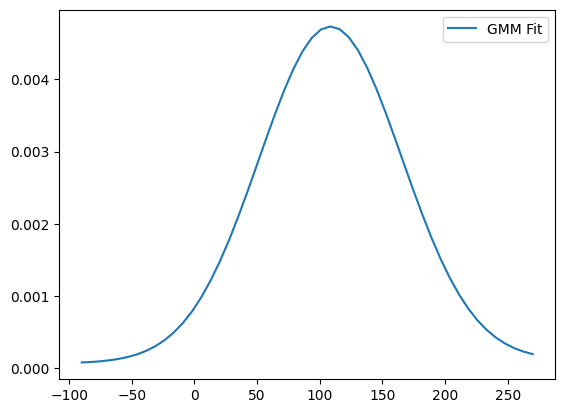

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming 'data' is your original data points

# Choose the number of components (K)
num_components = 2
data = theta_hist_nums
# Fit GMM
gmm = GaussianMixture(n_components=num_components, random_state=42)
gmm.fit(data.reshape(-1,1))

# Generate points for plotting the GMM fit
x = np.linspace(-90,270)
y = np.exp(gmm.score_samples(x.reshape(-1, 1)))

# Plot histogram and GMM fit
# plt.hist(data, bins=360, density=True, alpha=0.5, label='Histogram')
plt.plot(x, y, label='GMM Fit')
plt.legend()
plt.show()